In [1]:
# ================================================

# 05_analysis.ipynb

# ================================================

# Model Evaluation and Analysis of GARCH and SV Models

# -----------------------------------------------

import sys
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

plt.ion

# --- Step 1: Define Shock Windows ---

SHOCK_WINDOWS = {
"covid_pre": ("2019-06-05", "2020-02-14"),
"covid_shock": ("2020-02-15", "2020-06-30"),
"covid_post": ("2020-07-01", "2021-03-31"),


"inflation_energy_pre": ("2021-04-01", "2022-01-31"),
"inflation_energy_shock": ("2022-02-01", "2022-12-31"),
"inflation_energy_post": ("2023-01-01", "2023-09-30"),

"oil_spike_pre": ("2023-10-01", "2024-06-30"),
"oil_spike_shock": ("2024-07-01", "2025-03-31"),
"oil_spike_post": ("2025-04-01", "2025-10-30"),
}




In [2]:
# --- Path Setup ---

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [3]:
# --- Import Custom Modules ---


from modules.data_utils import tickers, fetch_data, load_data, load_split_manifest
from modules.garch_utils import garch_neg_loglik, forecast_garch_all_assets
from modules.plot_utils import plot_rolling_garch_vs_sv, _save_and_show_plot
from modules.sv_utils import sv_neg_loglik, forecast_sv_all_assets



In [4]:
# --- Quick check: window lengths per shock (in days) ---
shock_definitions = {
    "covid": ("2020-02-15", "2020-06-30"),
    "inflation_energy": ("2022-02-01", "2022-12-31"),
    "oil_spike": ("2024-07-01", "2025-03-31"),
}

for shock, (start, end) in shock_definitions.items():
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    pre_len   = (start - pd.Timestamp("2020-01-01")).days   #  use test_start dynamically
    shock_len = (end - start).days
    post_len  = (pd.Timestamp("2025-03-31") - end).days     #  use test_end dynamically
    print(f"{shock}: pre ≈ {pre_len} days, shock ≈ {shock_len} days, post ≈ {post_len} days")


covid: pre ≈ 45 days, shock ≈ 136 days, post ≈ 1735 days
inflation_energy: pre ≈ 762 days, shock ≈ 333 days, post ≈ 821 days
oil_spike: pre ≈ 1643 days, shock ≈ 273 days, post ≈ 0 days


In [5]:
# ----------------------------------------

# 1. Apply GARCH Forecasts (Test Data)

# ----------------------------------------



def apply_garch_all(
tickers,
params1=None, params2=None, dist='student_t', nu=5,
garch_dir="results/garch", split_dir="data/splits",
rv_window=20
):
  
    # Apply GARCH forecasts for all tickers using updated forecast_garch_all_assets.
    # Saves CSVs automatically and returns a dictionary of DataFrames.
    # Works with a list of tickers.
    
    import os
    os.makedirs(garch_dir, exist_ok=True)
    forecast_results = {}

    # Default placeholder parameters
    if params1 is None:
        params1 = [7.801e-03,0.054,0.918]
    if params2 is None:
        params2 = [1.061e-02,0.073, 0.887]

    print("=== Applying GARCH Forecasts (vectorized, single call per ticker) ===")

    # Support list input
    for name in tickers:
        try:
            df_test = forecast_garch_all_assets(
                name=name,
                omega_first=params1[0], alpha_first=params1[1], beta_first=params1[2],
                omega_second=params2[0], alpha_second=params2[1], beta_second=params2[2],
                split_dir=split_dir,
                train_dir="models/garch",
                save_dir=garch_dir,
                rv_window=rv_window,
                dist=dist,
                nu=nu
            )
            forecast_results[name] = df_test
            print(f"Forecast completed for {name}")
        except Exception as e:
            print(f"Forecast failed for {name}: {e}")

    print("\nAll GARCH forecasts complete.")
    return forecast_results
 


def apply_sv_all(
tickers,
params1=None, params2=None, dist='normal',
sv_dir="results/sv", split_dir="data/splits",
nu_fixed=8, sv_window=20
):

   #  Apply SV forecasts for all tickers using forecast_sv_all_assets.
   #  Saves CSVs automatically and returns a dictionary of DataFrames.
   #  Works with a list of tickers.
   

       

    os.makedirs(sv_dir, exist_ok=True)
    forecast_results = {}

    # Default placeholder parameters
    if params1 is None:
        params1 = [-0.000001, 0.949999,0.200000]
    if params2 is None:
        params2 = [0.000000, 0.950000,0.200000]

    print("=== Applying SV Forecasts (vectorized, single call per ticker) ===")

    for name in tickers:
        try:
            df_test = forecast_sv_all_assets(
                name=name,
                mu_first=params1[0], phi_first=params1[1], sigma_first=params1[2],
                mu_second=params2[0], phi_second=params2[1], sigma_second=params2[2],
                dist=dist,
                nu=nu_fixed,
                split_dir=split_dir,
                save_dir=sv_dir,
                sv_window=sv_window
            )
            forecast_results[name] = df_test
            print(f"Forecast completed for {name}")
        except Exception as e:
            print(f"Forecast failed for {name}: {e}")

    print("\nAll SV forecasts complete.")
    return forecast_results




In [6]:
    # ----------------------------------------
    # 4. Plot Comparison (Rolling vs GARCH vs SV)
    # ----------------------------------------
def plot_full_forecast_comparison_compact(
    tickers,
    train_end="2019-06-05",
    garch_dir="results/garch",
    sv_dir="results/sv",
    sv_smooth_window=5,
    calib_date="2020-09-30",
    ncols=2
):
   
    # Grid plot: Difference + Ratio for multiple tickers.
   
    tickers_list = list(tickers.keys())
    n = len(tickers_list)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows*2, ncols, figsize=(6*ncols, 4*nrows*2))
    axes = np.array(axes).reshape(nrows, ncols, 2)  # 0=difference, 1=ratio

    for idx, name in enumerate(tickers_list):
        row = idx // ncols
        col = idx % ncols
        try:
            # Load forecasts
            garch_df = pd.read_csv(f"{garch_dir}/{name}_garch_test.csv", parse_dates=["date"])
            sv_df = pd.read_csv(f"{sv_dir}/{name}_sv_test.csv", parse_dates=["date"])
            if garch_df.empty or sv_df.empty:
                print(f"No data for {name}, skipping.")
                continue

            # Align SV one-step-ahead
            sv_aligned = sv_df.set_index("date").reindex(garch_df['date']).shift(1)
            sv_aligned['sv_vol'] = sv_aligned['sv_vol'].ffill()
            sv_aligned['sv_vol_smooth'] = sv_aligned['sv_vol'].rolling(window=sv_smooth_window, min_periods=1).mean()

            # Merge into GARCH dataframe
            df = garch_df.copy()
            df['sv_vol'] = sv_aligned['sv_vol_smooth'].values

            # Plot
            plot_rolling_garch_vs_sv(
                name=name,
                df=df,
                train_end=train_end,
                sv_smooth_window=sv_smooth_window,
                calib_date=calib_date,
                ax_dict={"ax_diff": axes[row, col, 0], "ax_ratio": axes[row, col, 1]}
            )

        except Exception as e:
            print(f"Plotting failed for {name}: {e}")

    # Remove extra axes
    total_plots = nrows * ncols
    for idx in range(len(tickers_list), total_plots):
        row = idx // ncols
        col = idx % ncols
        fig.delaxes(axes[row, col, 0])
        fig.delaxes(axes[row, col, 1])

    plt.tight_layout()
    plt.show()




Running GARCH and SV forecasts ...
[OK] Loaded manifest for pre_covid (3 assets).
=== Applying GARCH Forecasts (vectorized, single call per ticker) ===
[OK] GARCH forecast saved for FX_USDINR
Forecast completed for FX_USDINR
[OK] GARCH forecast saved for BOND_BNDX
Forecast completed for BOND_BNDX
[OK] GARCH forecast saved for COM_CRUDE
Forecast completed for COM_CRUDE

All GARCH forecasts complete.
=== Applying SV Forecasts (vectorized, single call per ticker) ===
[OK] SV forecast saved for FX_USDINR
Forecast completed for FX_USDINR
[OK] SV forecast saved for BOND_BNDX
Forecast completed for BOND_BNDX
[OK] SV forecast saved for COM_CRUDE
Forecast completed for COM_CRUDE

All SV forecasts complete.


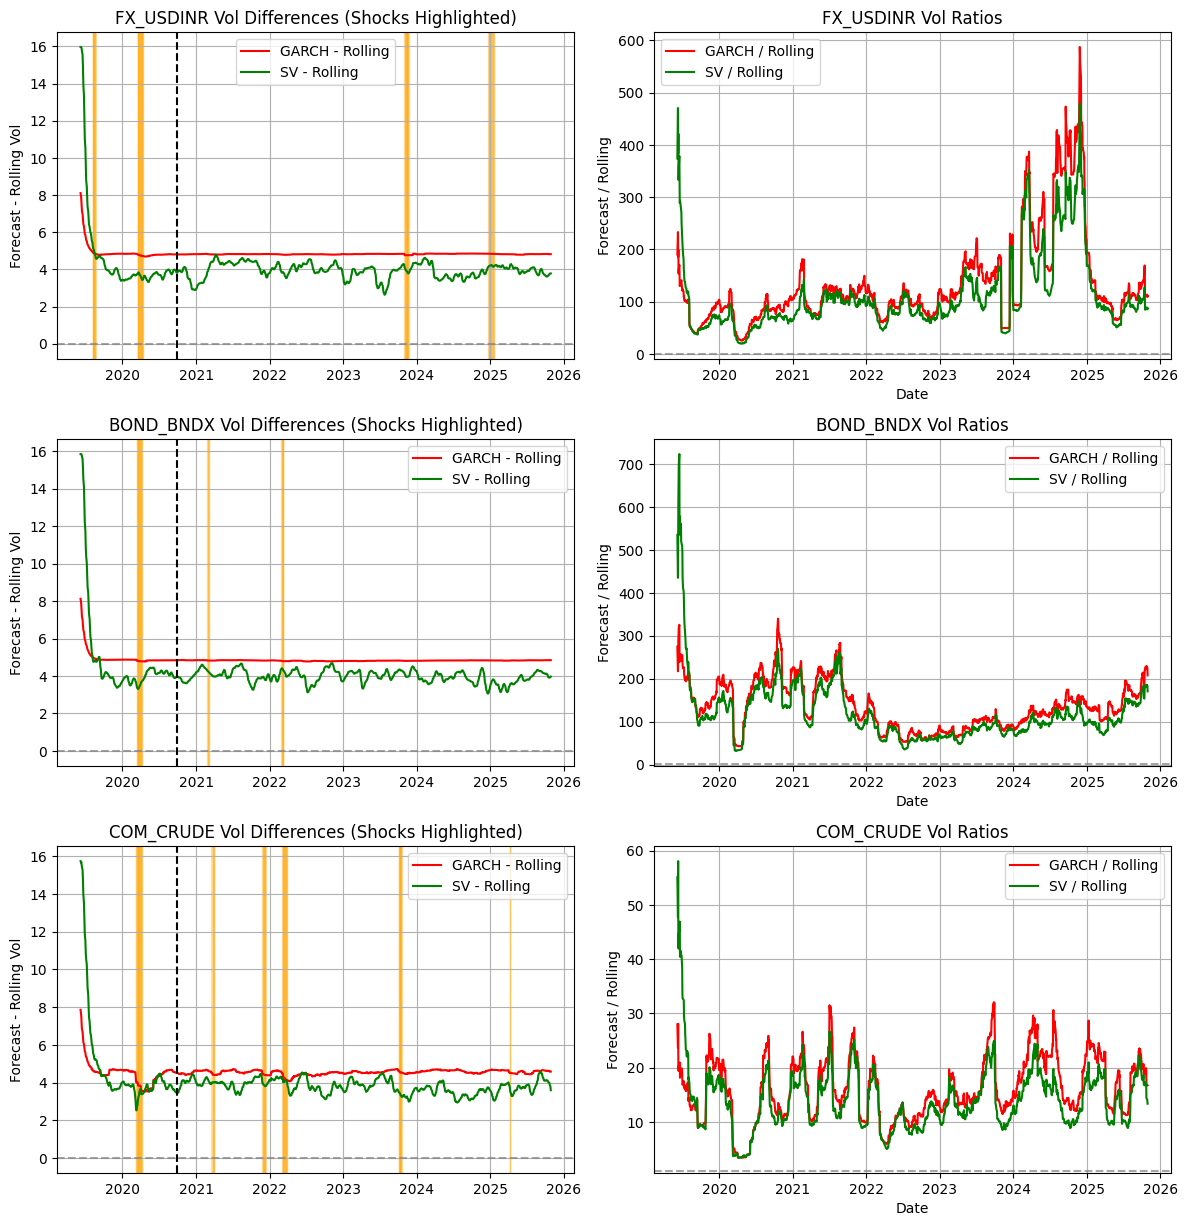

In [7]:
# ----------------------------------------
# 6. Run Forecasts and Evaluate
# ----------------------------------------

print("Running GARCH and SV forecasts ...")
# reload manifest so we have the dictionary again
from modules.data_utils import load_split_manifest

manifest = load_split_manifest("pre_covid")
train_paths = dict(zip(manifest["asset"], manifest["train_path"]))

# Use train_paths directly
apply_garch_all(train_paths, dist="student_t")
apply_sv_all(train_paths)


# Optional: plot comparisons
shock_windows = [
   ("2020-02-15", "2020-06-30"),("2022-02-01", "2022-12-31"),
  ("2024-07-01", "2025-03-31"),
]

plot_full_forecast_comparison_compact(
    tickers,
    garch_dir="results/garch",
    sv_dir="results/sv",
    sv_smooth_window=5,
    calib_date="2020-09-30"
)




